# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Наша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

## Откройте файл с данными и изучите общую информацию.

### 1. Загрузите данные из файла в датафрейм.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
try:
    data = pd.read_csv('real_estate_data.csv', sep='\t')
except:
    data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

### 2. Изучите общую информацию о полученном датафрейме.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Первично уже можем видеть с каких именно столбцах обнаружены пропуски (**ceiling_height**, **living_area**, **is_apartment**, **kitchen_area**, **balcony**). Также в некоторых столбцах видим несоответствие типов данных (например, **first_day_exposition** имеет тип данных *object* вместо *datetime*)

### 3. Постройте общую гистограмму для всех числовых столбцов таблицы.

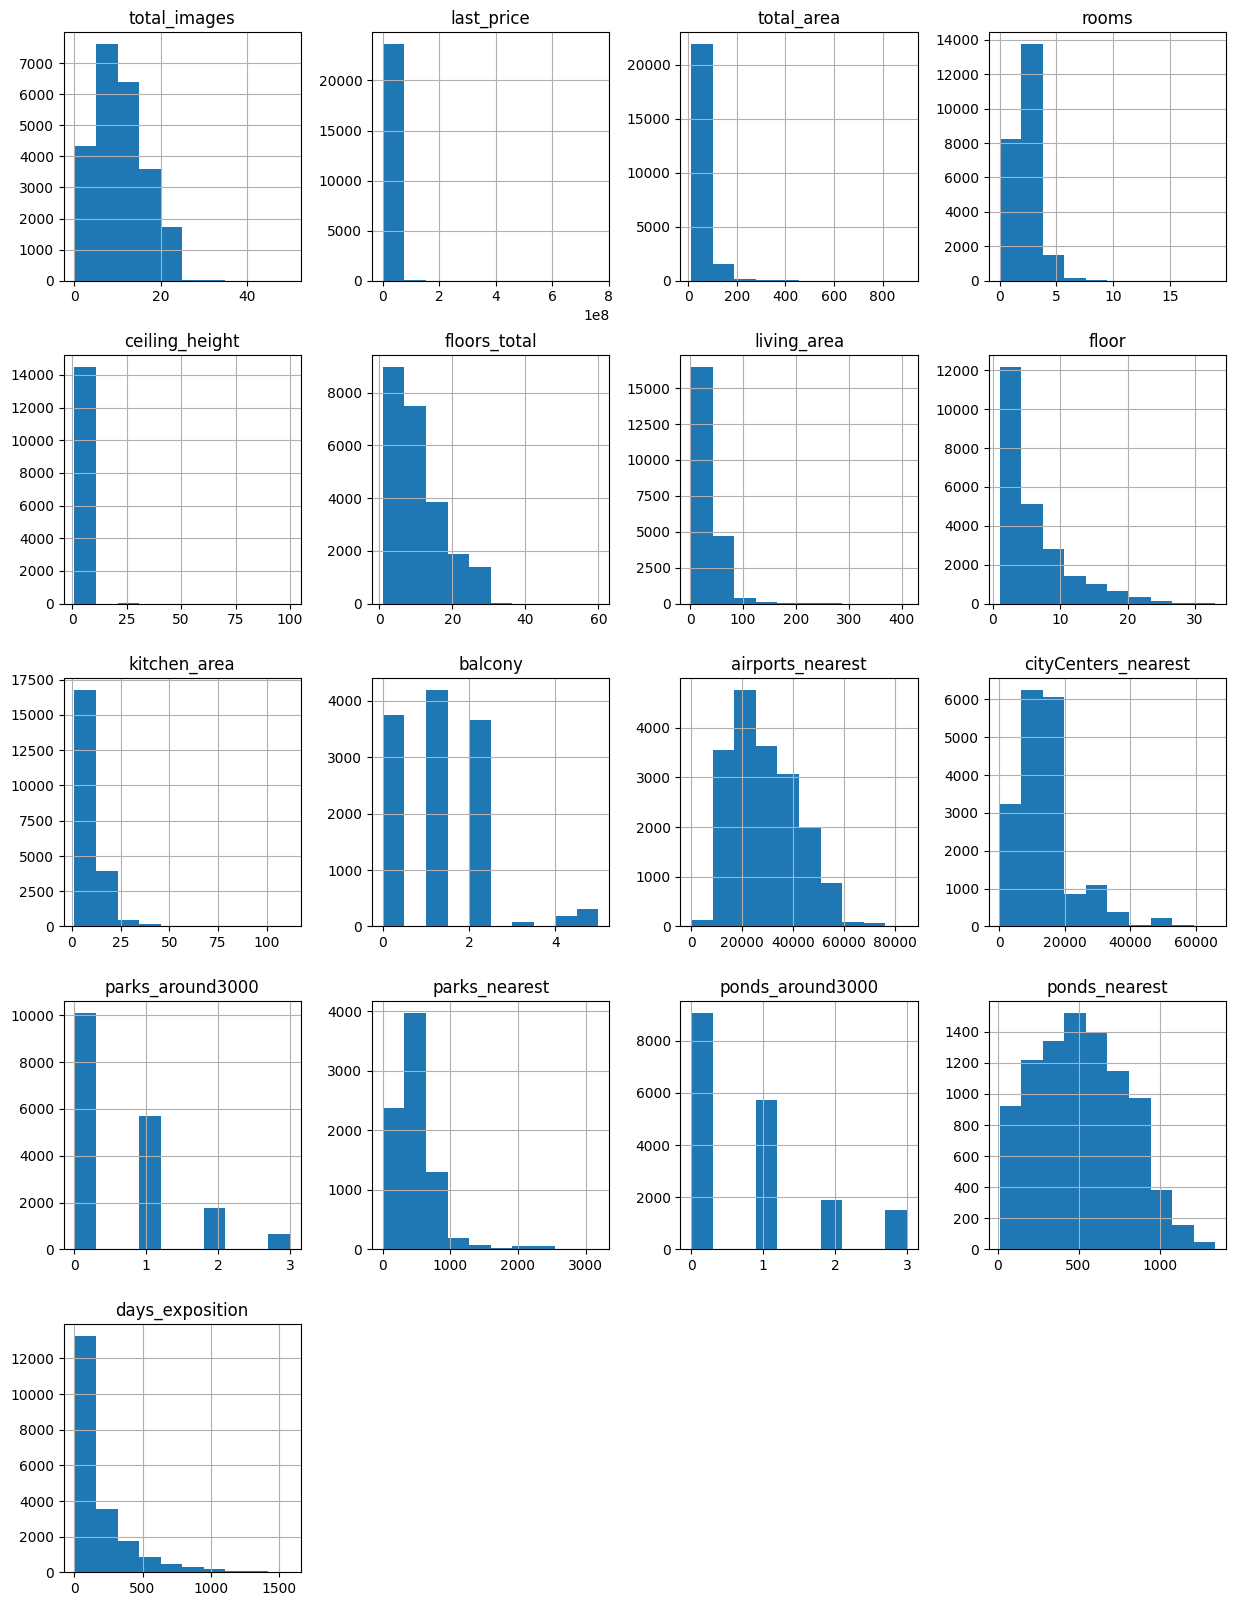

In [4]:
data.hist(figsize=(15, 20))
plt.show()

### Промежуточный вывод к первому этапу:

Выгрузили и первоначально познакомились с данными, просмотрели столбцы с отсутствующими значениями, изначальные типы данных, а также на распределение по гистограммам.

## Предобработка данных

### 1. Найдите и изучите пропущенные значения в столбцах:

Добавим информацию о столбцах в датафрейме:
* **airports_nearest** — расстояние до ближайшего аэропорта в метрах (м)
* **balcony** — число балконов
* **ceiling_height** — высота потолков (м)
* **cityCenters_nearest** — расстояние до центра города (м)
* **days_exposition** — сколько дней было размещено объявление (от публикации до снятия)
* **first_day_exposition** — дата публикации
* **floor** — этаж
* **floors_total** — всего этажей в доме
* **is_apartment** — апартаменты (булев тип)
* **kitchen_area** — площадь кухни в квадратных метрах (м²)
* **last_price** — цена на момент снятия с публикации
* **living_area** — жилая площадь в квадратных метрах (м²)
* **locality_name** — название населённого пункта
* **open_plan** — свободная планировка (булев тип)
* **parks_around3000** — число парков в радиусе 3 км
* **parks_nearest** — расстояние до ближайшего парка (м)
* **ponds_around3000** — число водоёмов в радиусе 3 км
* **ponds_nearest** — расстояние до ближайшего водоёма (м)
* **rooms** — число комнат
* **studio** — квартира-студия (булев тип)
* **total_area** — общая площадь квартиры в квадратных метрах (м²)
* **total_images** — число фотографий квартиры в объявлении


Посмотрим в каких столбцах есть пропущенные значение и посчитаем количество:

In [5]:
data.isna().sum()

,0
total_images,0
last_price,0
total_area,0
first_day_exposition,0
rooms,0
ceiling_height,9195
floors_total,86
living_area,1903
floor,0
is_apartment,20924


Сразу же можем смело изменять данные в столбцах **is_apartment** (предположим там, где есть пропуски, квартиры не относятся к типу апартаментов) и **balcony** (здесь, скорее всего, нет балконов в квартире). Также обратим внимание, что в столбцах **parks_around3000** и **ponds_around3000** одинаковое количество пропущенных значений. Здесь можно предположить, что они говорят об отсутствии парков и водоёмов в радиусе 3 км от квартиры, поэтому их значения заменим также на 0. Сразу же изменяем тип данных на целочисленный в тех столбцах, где это подразумевается, ведь не может быть вещественным числом количество балконов, прудов или парков:

In [6]:
data['is_apartment'] = data['is_apartment'].fillna(False)
data['balcony'] = data['balcony'].fillna(0).astype('int')
data['parks_around3000'] = data['parks_around3000'].fillna(0).astype('int')
data['ponds_around3000'] = data['ponds_around3000'].fillna(0).astype('int')

Причины, по которым могли быть пропущены данные в измененных столбцах, вероятнее всего человеческих фактор, неправильное заполнение формы, всвязи с чем появились проблемы с данными на этапе выгрузки.


Продолжаем рассматривать пропущенные значения в данных. В столбцах **floors_total** и **locality_name** слишком маленькое количество потерянных данных, поэтому мы без проблем можем удалить эти строчки, чтобы в будущем они не мешали нам при расчётах. Также изменяем в столбце **floors_total** тип данных на целочисленный, так как вещественного там быть не может:

In [7]:
data = data.dropna(subset=['floors_total', 'locality_name']).reset_index(drop=True)
data['floors_total'] = data['floors_total'].astype('int')

Данные пропуски можем отнести к случайному типу, так как здесь мог играть роль как человеческий фактор, так и техническая неисправность.

Далее рассмотрим более подробно столбец **days_exposition**. Здесь пропуски могут быть обусловлены ещё не закрывшимися объявлениями. Заменим пропуски несуществующими значением (-1), чтобы понимать, что некоторые объекты ещё не проданы. Также сразу поменяем тип данных на целочисленный, так как дни не могут иметь вещественные значения:

In [8]:
data['days_exposition'] = data['days_exposition'].fillna(-1).astype('int')
data['days_exposition'].isna().sum()

0

Рассмотрим подробнее пропуски в столбце **ceiling_height**. В данном случае пропуски, скорее всего, имеют случайный характер, которые могли образоваться в виду повреждения файла с данными или же по причине лени авторов объявлений при заполнении пунктов. Здесь попробуем заменить их медианым значением с помощью группировки по значениям **locality_name**.:

In [9]:
data['ceiling_height'] = data['ceiling_height'].fillna(data.groupby('locality_name')['ceiling_height'].transform('median'))
data['ceiling_height'].isna().sum()

120

После выполнения замены пропусков видим, что ещё остались пропущенные значения. Здесь будем заменять пропуски на медианое значение по всему столбцу:

In [10]:
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())

Далее разберёмся со столбцами **living_area** и **kitchen_area**. Здесь для заполнения пропусков будем ориентироваться на общую площадь квартиры и воспользуемся столбцом **total_area**, чтобы выявить более объективное медианое значение:

In [11]:
data['living_area'] = data['living_area'].fillna(data.groupby('total_area')['living_area'].transform('median'))
data['living_area'].isna().sum()

133

In [12]:
data['kitchen_area'] = data['kitchen_area'].fillna(data.groupby('total_area')['kitchen_area'].transform('median'))
data['kitchen_area'].isna().sum()

185

Видим, что для каких-то пропусков медианого значения не нашлось, но таких строк очень маленькое количество, поэтому можем проигнорировать данные для дальнейших расчётов.

In [13]:
data = data.dropna(subset=['living_area', 'kitchen_area']).reset_index(drop=True)

Пропуски в этих столбцах можем также отнести к случайным, то есть они могли возникнуть в процессе обработки файла с данными, его выгрузки и повреждения в системе.

В некоторых столбцах ещё остаются пропуски, но пока ещё сложновато понять, какими именно данными мы можем заполнить пропуски, но от такого огромного количества данных отказаться мы не можем. Поэтому в остальных столбцах пока что оставим пропуски, но заполним их несуществующим значением, которое будет нам говорить о существовании отсутствующих значений. Также меням тип данных на целочисленный, в тех столбцах, где это предусматривает измерение (расстояние до объектов в метрах не может быть вещественным):

In [14]:
data['airports_nearest'] = data['airports_nearest'].fillna(-1).astype('int')
data['cityCenters_nearest'] = data['cityCenters_nearest'].fillna(-1).astype('int')
data['parks_nearest'] = data['parks_nearest'].fillna(-1).astype('int')
data['ponds_nearest'] = data['ponds_nearest'].fillna(-1).astype('int')
data.isna().sum()

,0
total_images,0
last_price,0
total_area,0
first_day_exposition,0
rooms,0
ceiling_height,0
floors_total,0
living_area,0
floor,0
is_apartment,0


Видим итог наших преобрзований: мы полностью избавились от явных пропусков.

### 2. Рассмотрите типы данных в каждом столбце:

Мы уже изменели тип данных там, где это необходимо в процессе заполнения пропусков. Просмотрим общую информацию по столбцам в данных и проанализируем, где ещё необходимо поменять тип данных:

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23290 entries, 0 to 23289
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23290 non-null  int64  
 1   last_price            23290 non-null  float64
 2   total_area            23290 non-null  float64
 3   first_day_exposition  23290 non-null  object 
 4   rooms                 23290 non-null  int64  
 5   ceiling_height        23290 non-null  float64
 6   floors_total          23290 non-null  int64  
 7   living_area           23290 non-null  float64
 8   floor                 23290 non-null  int64  
 9   is_apartment          23290 non-null  bool   
 10  studio                23290 non-null  bool   
 11  open_plan             23290 non-null  bool   
 12  kitchen_area          23290 non-null  float64
 13  balcony               23290 non-null  int64  
 14  locality_name         23290 non-null  object 
 15  airports_nearest   

Можем увидеть, что осталось поменять тип данных только для столбца first_day_exposition, так как корректно, чтобы для него отображался тип даты:

In [16]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23290 entries, 0 to 23289
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23290 non-null  int64         
 1   last_price            23290 non-null  float64       
 2   total_area            23290 non-null  float64       
 3   first_day_exposition  23290 non-null  datetime64[ns]
 4   rooms                 23290 non-null  int64         
 5   ceiling_height        23290 non-null  float64       
 6   floors_total          23290 non-null  int64         
 7   living_area           23290 non-null  float64       
 8   floor                 23290 non-null  int64         
 9   is_apartment          23290 non-null  bool          
 10  studio                23290 non-null  bool          
 11  open_plan             23290 non-null  bool          
 12  kitchen_area          23290 non-null  float64       
 13  balcony         

Также для удобства округлим даты до 1 дня, так как информации о времени размещения объявлений у нас в любом случае отсутствует:

In [17]:
data['first_day_exposition'] = data['first_day_exposition'].dt.round('1D')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.700,16,51.0,8,False,...,25.0,0,Санкт-Петербург,18863,16028,1,482,2,755,-1
1,7,3350000.0,40.4,2018-12-04,1,2.615,11,18.6,1,False,...,11.0,2,посёлок Шушары,12817,18603,0,-1,0,-1,81
2,10,5196000.0,56.0,2015-08-20,2,2.700,5,34.3,4,False,...,8.3,0,Санкт-Петербург,21741,13933,1,90,2,574,558
3,0,64900000.0,159.0,2015-07-24,3,2.700,14,95.0,9,False,...,15.0,0,Санкт-Петербург,28098,6800,2,84,3,234,424
4,2,10000000.0,100.0,2018-06-19,2,3.030,14,32.0,13,False,...,41.0,0,Санкт-Петербург,31856,8098,2,112,1,48,121


### 3. Изучите уникальные значения в столбце с названиями и устраните неявные дубликаты.

Приведём все названия населённых пунктов к нижнему регистру для удобства:

In [18]:
data['locality_name'] = data['locality_name'].str.lower()

Выведем и посчитаем количество уникальных значений в столбце, чтобы сравнить с изменённым столбцом:

In [19]:
data['locality_name'].unique()

array(['санкт-петербург', 'посёлок шушары', 'городской посёлок янино-1',
       'посёлок парголово', 'посёлок мурино', 'ломоносов', 'сертолово',
       'петергоф', 'пушкин', 'деревня кудрово', 'коммунар', 'колпино',
       'поселок городского типа красный бор', 'гатчина', 'поселок мурино',
       'деревня фёдоровское', 'выборг', 'кронштадт', 'кировск',
       'деревня новое девяткино', 'посёлок металлострой',
       'посёлок городского типа лебяжье',
       'посёлок городского типа сиверский', 'поселок молодцово',
       'поселок городского типа кузьмоловский',
       'садовое товарищество новая ропша', 'павловск',
       'деревня пикколово', 'всеволожск', 'волхов', 'кингисепп',
       'приозерск', 'сестрорецк', 'деревня куттузи', 'посёлок аннино',
       'поселок городского типа ефимовский', 'посёлок плодовое',
       'деревня заклинье', 'поселок торковичи', 'поселок первомайское',
       'красное село', 'посёлок понтонный', 'сясьстрой', 'деревня старая',
       'деревня лесколово', '

In [20]:
data['locality_name'].nunique()

363

Используем метод replace() для изменения названий, чтобы сократить количество неявных дубликатов и проверяем результат, подсчитывая уникальные значения:

In [21]:
data['locality_name'] = data['locality_name'].str.replace('ё', 'е')
data['locality_name'] = data['locality_name'].str.replace('городской поселок', 'поселок')
data['locality_name'] = data['locality_name'].str.replace('коттеджный поселок', 'поселок')
data['locality_name'] = data['locality_name'].str.replace('садоводческое некоммерческое товарищество', 'садовое товарищество')
data['locality_name'] = data['locality_name'].str.replace('поселок городского типа', 'поселок')
data['locality_name'] = data['locality_name'].str.replace('деревня', 'поселок')
data['locality_name'] = data['locality_name'].str.replace('садовое товарищество', 'поселок')
data['locality_name'].nunique()

312

### 4. Найдите и устраните редкие и выбивающиеся значения.

Отобразим числовое описание данных всей таблицы и проанализируем показатели по каждому столбцу:

In [22]:
data.describe()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23290.000000,2.329000e+04,23290.000000,23290,23290.000000,23290.000000,23290.00000,23290.000000,23290.000000,23290.000000,23290.000000,23290.000000,23290.000000,23290.000000,23290.000000,23290.000000,23290.000000,23290.000000
mean,9.904079,6.486479e+06,60.162800,2017-11-09 02:58:04.070416384,2.075655,2.733370,10.62705,34.524420,5.855646,10.429086,0.592787,22086.138600,10915.748304,0.469858,166.675526,0.588321,198.169472,156.629884
min,0.000000,1.219000e+04,14.000000,2014-11-27 00:00:00,0.000000,1.000000,1.00000,2.000000,1.000000,1.300000,0.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000
25%,6.000000,3.450000e+06,40.000000,2017-05-15 00:00:00,1.000000,2.550000,5.00000,18.700000,2.000000,7.000000,0.000000,10318.000000,2299.750000,0.000000,-1.000000,0.000000,-1.000000,22.000000
50%,9.000000,4.650000e+06,52.000000,2017-12-12 00:00:00,2.000000,2.700000,9.00000,30.000000,4.000000,9.000000,0.000000,21867.000000,11285.000000,0.000000,-1.000000,0.000000,-1.000000,74.000000
75%,14.000000,6.774440e+06,69.700000,2018-08-24 00:00:00,3.000000,2.700000,16.00000,42.300000,8.000000,11.800000,1.000000,34324.000000,15254.000000,1.000000,302.000000,1.000000,390.000000,199.000000
max,50.000000,7.630000e+08,900.000000,2019-05-03 00:00:00,19.000000,100.000000,60.00000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000
std,5.683116,1.064312e+07,34.341993,NaN,1.070825,1.017807,6.57220,21.802869,4.854872,5.747876,0.959348,16453.853929,9649.441559,0.748948,306.090196,0.882286,305.733451,213.732375


**total_images** - вполне реалистичные данные, оставляем столбец без изменений.



**last_price** - данные выглядят достаточно правдиво, но слишком смущает минимальная стоимость квартиры (всего 12190 руб) и максимальная (аж 763 млн руб). Построим гистограмму, чтобы более детально рассмотреть данные:

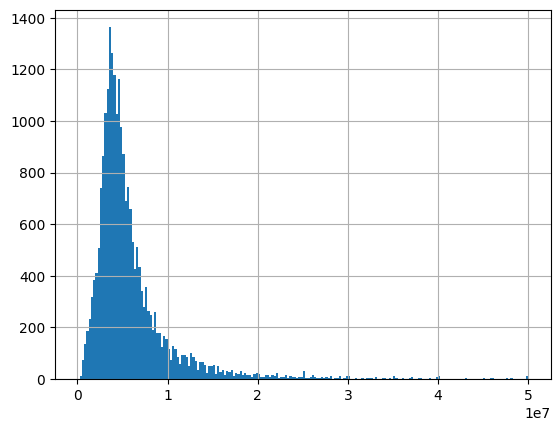

In [23]:
data['last_price'].hist(bins=200, range=(0, 50000000))
plt.show()

Поэксперементировав с графиком, выявили, что значения по стоимости квартир ниже 400 тыс выше 50 млн руб можно исключить из выборки, как аномальные значения. Также подсчитаем количество, чтобы точно быть уверенными, что таких данных не много:

In [24]:
data.query('last_price > 50000000')['last_price'].count()

120

In [25]:
data.query('last_price < 400000')['last_price'].count()

1

In [26]:
data.drop(index=data.query('last_price > 50000000').index,inplace=True)
data.drop(index=data.query('last_price < 400000').index,inplace=True)

**total_area** - в этом столбце смущает максимальное значение, построим гистограмму:

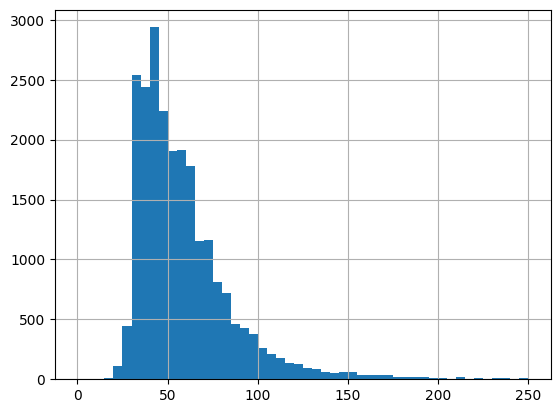

In [27]:
data['total_area'].hist(bins=50, range=(0, 250))
plt.show()

In [28]:
data.query('total_area > 250')['total_area'].count()

49

Поигравшись с графиком, также можем выделить аномальные данные - это свыше 250 м2, избавимся от этих значений:

In [29]:
data.drop(index=data.query('total_area > 250').index,inplace=True)

**rooms** - очень смущает наличие квартир, где количество комнат 0, но это могут быть апартаменты или же свободная планировка, проверим, насколько это соответсвует действительности. Максимальное количество комнат 19, это многовато, но тоже имеет место быть.

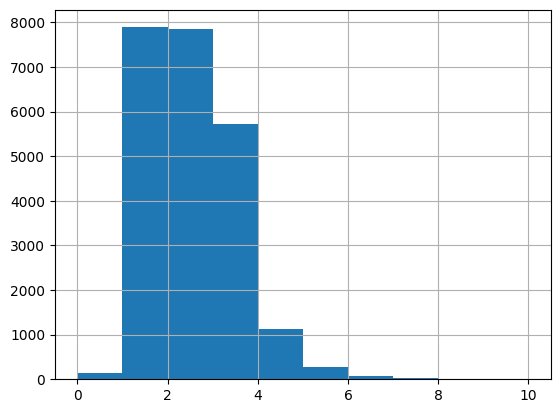

In [30]:
data['rooms'].hist(bins=10, range=(0, 10))
plt.show()

In [31]:
data.query('rooms == 0')['rooms'].count()

139

In [32]:
data.query('rooms == 0 and (studio or is_apartment or open_plan)')['rooms'].count()

139

Теория о нулевых комнатах в квартирах оправдалась, поэтому эти данные тоже оставляем.

**ceiling_height** - максимальная высота потолков аж 100 метров, это конечно же невозможно. Минимальная высота потолка также смущает, всего лишь 1 метр.  Будем допускать, что максимальная высота потолка в квартире составляет 4 метра, а минимальная 2,2 метра. Очевидно, что данные от 22 до 40 метров - это ошибка, вызванная человеческим фактором при заполнении формы при создании объявления. Поэтому значения в данном столбце от 4 и до 22 метров, свыше 40 метров, а также менее 2,2 метров удаляем, как выбросы, а данные от 22 до 40 метров сохраняем, предварительно поделив на 10:

In [33]:
data.query('ceiling_height < 2.2')['ceiling_height'].count()

14

In [34]:
data.drop(index=data.query('ceiling_height > 4 and ceiling_height < 22').index,inplace=True)
data.drop(index=data.query('ceiling_height > 40').index,inplace=True)
data.drop(index=data.query('ceiling_height < 2.2').index,inplace=True)

In [35]:
def ceiling_height_normal(row):
     if row['ceiling_height'] > 22:
        return row['ceiling_height'] * 0.1
     else:
        return row['ceiling_height']

In [36]:
data['ceiling_height'] = data.apply(ceiling_height_normal, axis=1)

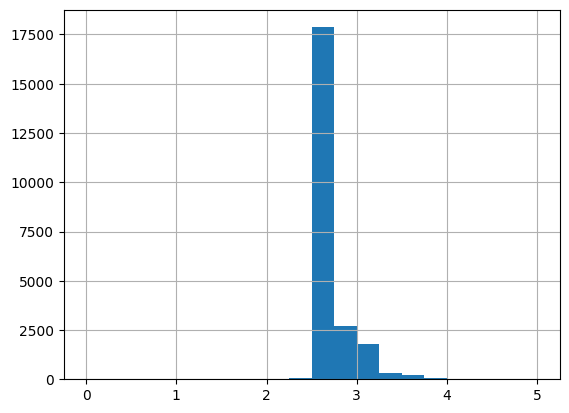

In [37]:
data['ceiling_height'].hist(bins=20, range=(0, 5))
plt.show()

**floors_total** - видим очевидно нереальную высоту максимального дома (целых 60 этажей). На данный момент самый высокий дом в Санкт-Петербурге - это 37 этажей, будем ориентироваться на него. Посмотрим, сколько домов у нас выходит за эти рамки:

In [38]:
data.query('floors_total > 37')['floors_total'].count()

2

Так как таких дома всего два, можем спокойно их отбросить, как аномальные значения:

In [39]:
data.drop(index=data.query('floors_total > 37').index,inplace=True)

**living_area** - здесь выглядит странно как минимальное значение (всего лишь 2 м2), так и максимальное (более 400 м2). Посмотрим на гистограмму:

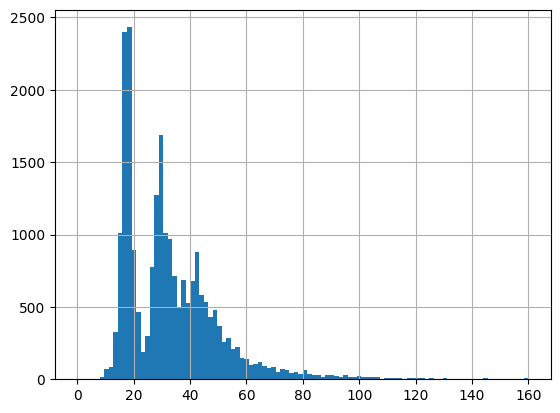

In [40]:
data['living_area'].hist(bins=100, range=(0, 160))
plt.show()

In [41]:
data.query('living_area < 10')['living_area'].count()

24

In [42]:
data.query('living_area > 160')['living_area'].count()

15

Если мы допускаем, что общая площадь у нас достигает до 250 м2, то смело можем предполагать, что максимальная площадь жилищной зоны 160 м2, более высокие значения можем отбросить, как аномалии. Также и с квартирами, где жилизная площадь состовляет менее 10 м2, их также проигнорируем.

In [43]:
data.drop(index=data.query('living_area < 10').index,inplace=True)
data.drop(index=data.query('living_area > 160').index,inplace=True)

**floor** - в этом столбце нет каких-то сомнений, все значения кажутся реалистичными.

**kitchen_area** - здесь стоит подкорректировать данные, так как минимальное значение кажется совсем уж нереалистично малым, а максимально чересчур большим (1,3 м2 и 112 м2 соответственно).

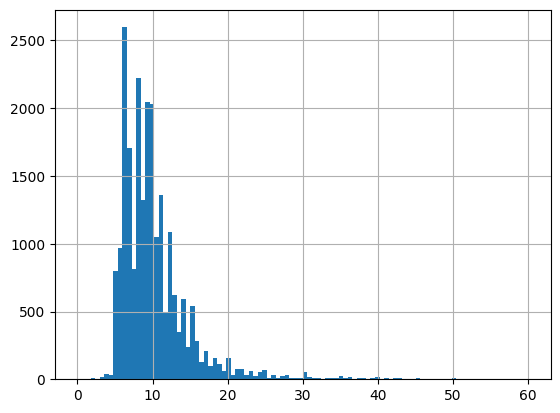

In [44]:
data['kitchen_area'].hist(bins=100, range=(0, 60))
plt.show()

In [45]:
data.query('kitchen_area < 4')['kitchen_area'].count()

36

In [46]:
data.query('kitchen_area > 60')['kitchen_area'].count()

9

Отбросим аномальные значения, где площадь кухни меньше 4 м2 и больше 60 м2:

In [47]:
data.drop(index=data.query('kitchen_area < 4').index,inplace=True)
data.drop(index=data.query('kitchen_area > 60').index,inplace=True)

**balcony** - данные выглядят реалистично и правдоподобно.

**days_exposition** - данные выглядят реалистично, также по гистриграмме видим нормальное распределение. Оставим данные прежними

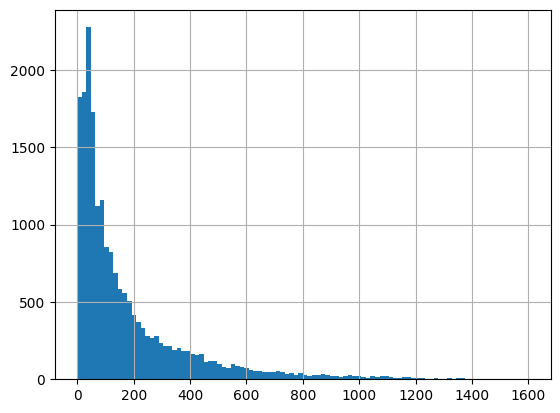

In [48]:
data['days_exposition'].hist(bins=100, range=(0, 1600))
plt.show()

**airports_nearest**, **cityCenters_nearest**, **parks_around3000**, **parks_nearest**, **ponds_around3000** и **ponds_nearest** - данные по этим столбцам были сгенерированы автоматически, каких-то вопросов к данным нет, также построили гистограммы по всем этим столбцам, диаграммы выглядят нормально.

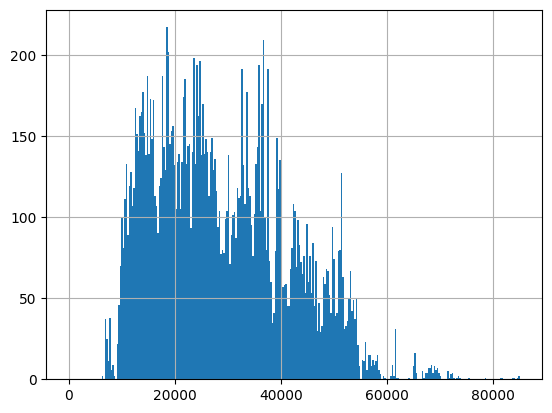

In [49]:
data['airports_nearest'].hist(bins=300, range=(0, 85000))
plt.show()

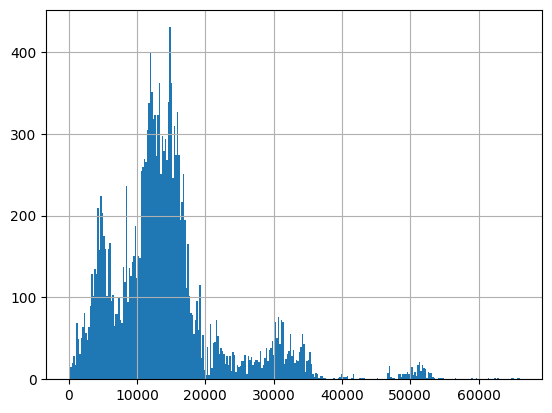

In [50]:
data['cityCenters_nearest'].hist(bins=300, range=(0, 66000))
plt.show()

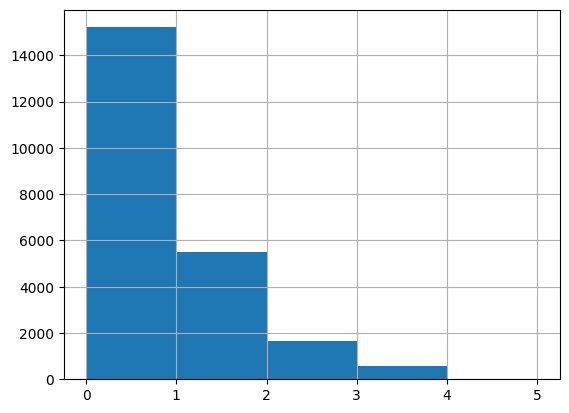

In [51]:
data['parks_around3000'].hist(bins=5, range=(0, 5))
plt.show()

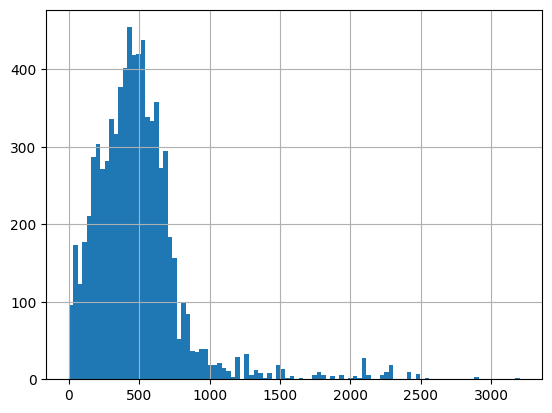

In [52]:
data['parks_nearest'].hist(bins=100, range=(0, 3200))
plt.show()

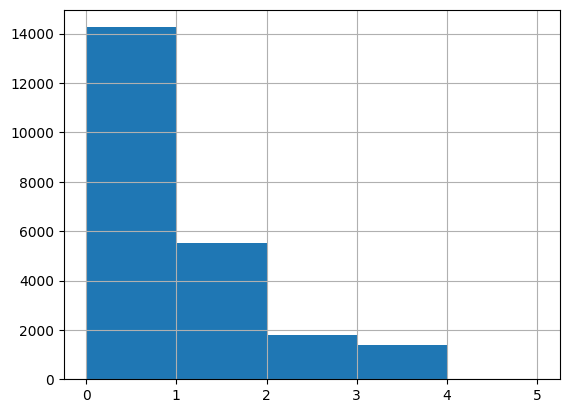

In [53]:
data['ponds_around3000'].hist(bins=5, range=(0, 5))
plt.show()

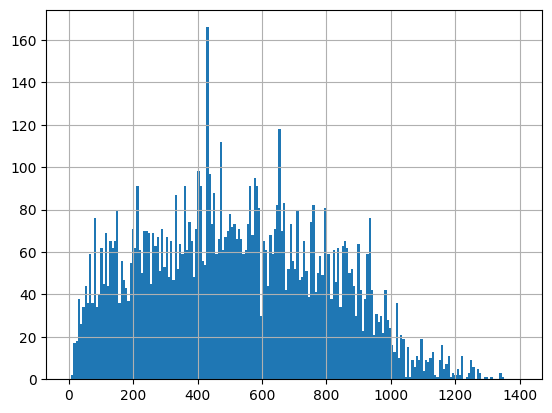

In [54]:
data['ponds_nearest'].hist(bins=200, range=(0, 1400))
plt.show()

In [55]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22974 entries, 0 to 23289
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22974 non-null  int64         
 1   last_price            22974 non-null  float64       
 2   total_area            22974 non-null  float64       
 3   first_day_exposition  22974 non-null  datetime64[ns]
 4   rooms                 22974 non-null  int64         
 5   ceiling_height        22974 non-null  float64       
 6   floors_total          22974 non-null  int64         
 7   living_area           22974 non-null  float64       
 8   floor                 22974 non-null  int64         
 9   is_apartment          22974 non-null  bool          
 10  studio                22974 non-null  bool          
 11  open_plan             22974 non-null  bool          
 12  kitchen_area          22974 non-null  float64       
 13  balcony              

### Промежуточный вывод по второму этапу:

Выполнили полноценную предобработку данных: посчитали по столбцам пропуски, везде, где это представлялось возможным, заполнили логическими значениями, в остальных столбцах заменили пропуски на несуществующие значения, так как это тоже послужит для нас информацией в последующих расчетах. Поменяли на корректный тип данных информацию по столбцам, где это было необходимо. Максимально очистили данные от неявных дубликатов, аномалий и выбросов. Выявили и исправили ошибку, который повлёк за собой человеческий фактор (столбец **ceiling_height**). В целом, подготовили данные для дальнейших расчётов и анализа.

## Посчитайте и добавьте в таблицу новые столбцы

### 1. Добавьте в таблицу новые столбцы со следующими параметрами:
* цена одного квадратного метра;

In [56]:
data['price_for_one_meter_sqr'] = (data['last_price'] / data['total_area']).round(2)

* день недели публикации объявления (0 — понедельник, 1 — вторник и так далее);

In [57]:
data['day_of_week_exposition'] = data['first_day_exposition'].dt.day_of_week

* месяц публикации объявления;

In [58]:
data['month_exposition'] = data['first_day_exposition'].dt.month

* год публикации объявления;

In [59]:
data['year_exposition'] = data['first_day_exposition'].dt.year

* тип этажа квартиры (значения — «первый», «последний», «другой»);

In [60]:
def category_floor(row):
    floor = row['floor']
    floors_total = row['floors_total']
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    else:
        return 'другой'

data['category_floor'] = data.apply(category_floor, axis=1)

* расстояние до центра города в километрах (переведите из м в км и округлите до целых значений).

In [61]:
data['cityCenters_nearest_km'] = (data['cityCenters_nearest'] / 1000).round(0).astype('int')

### Промежуточный вывод по третьему этапу:
Посчитали и добавили в таблицу все данные требующиеся пр условию задания.

## Проведите исследовательский анализ данных

### 1. Изучите следующие параметры объектов:
* общая площадь;
* жилая площадь;
* площадь кухни;
* цена объекта;
* количество комнат;
* высота потолков;
* этаж квартиры;
* тип этажа квартиры («первый», «последний», «другой»);
* общее количество этажей в доме;
* расстояние до центра города в метрах;
* расстояние до ближайшего аэропорта;
* расстояние до ближайшего парка;
* день и месяц публикации объявления.

Для начала анализа нащих параметров, загрузим общую числовую информацию по столбцам, а также построим отдельные гистограммы для каждого из них:

In [62]:
data.describe()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_for_one_meter_sqr,day_of_week_exposition,month_exposition,year_exposition,cityCenters_nearest_km
count,22974.000000,2.297400e+04,22974.000000,22974,22974.000000,22974.000000,22974.000000,22974.000000,22974.000000,22974.000000,...,22974.000000,22974.000000,22974.000000,22974.000000,22974.000000,22974.000000,22974.000000,22974.000000,22974.000000,22974.000000
mean,9.879777,5.908392e+06,58.500205,2017-11-10 04:26:42.089318144,2.050187,2.696667,10.660007,33.572655,5.860669,10.236436,...,0.461043,165.332985,0.579089,197.252677,155.896492,97295.987075,2.566989,6.392487,2017.371246,10.960651
min,0.000000,4.300000e+05,20.000000,2014-11-27 00:00:00,0.000000,2.200000,1.000000,10.000000,1.000000,4.000000,...,0.000000,-1.000000,0.000000,-1.000000,-1.000000,7962.960000,0.000000,1.000000,2014.000000,0.000000
25%,6.000000,3.430000e+06,40.000000,2017-05-15 00:00:00,1.000000,2.550000,5.000000,18.700000,2.000000,7.000000,...,0.000000,-1.000000,0.000000,-1.000000,22.000000,76190.480000,1.000000,3.000000,2017.000000,2.000000
50%,9.000000,4.600000e+06,52.000000,2017-12-12 00:00:00,2.000000,2.700000,9.000000,30.000000,4.000000,9.000000,...,0.000000,-1.000000,0.000000,-1.000000,73.000000,94666.670000,3.000000,6.000000,2017.000000,11.000000
75%,14.000000,6.700000e+06,69.000000,2018-08-25 00:00:00,3.000000,2.700000,16.000000,42.000000,8.000000,11.600000,...,1.000000,297.750000,1.000000,385.000000,198.000000,113461.540000,4.000000,10.000000,2018.000000,15.000000
max,50.000000,5.000000e+07,250.000000,2019-05-03 00:00:00,11.000000,4.000000,36.000000,160.000000,33.000000,60.000000,...,3.000000,3190.000000,3.000000,1344.000000,1580.000000,848484.850000,6.000000,12.000000,2019.000000,66.000000
std,5.668316,4.715088e+06,27.232294,NaN,1.006511,0.204678,6.560400,17.937352,4.858378,5.016238,...,0.739135,305.483075,0.874231,305.890395,212.872435,39252.157304,1.788815,3.491549,1.036416,9.672540


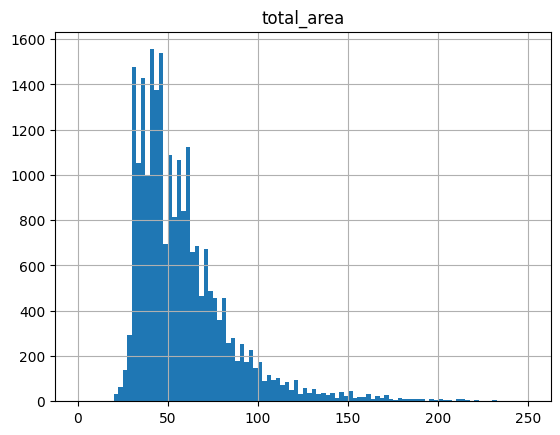

In [63]:
data.hist('total_area', bins=100, range=(0, 250))
plt.show()

*Общая площадь*: распределение по общей площади квартир выглядит нормальным, пик данных находится на диапозоне от 40 до 50 кв м, что кажется достаточно реалистичным.

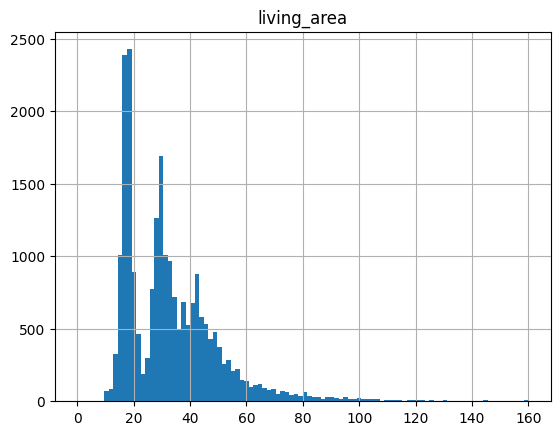

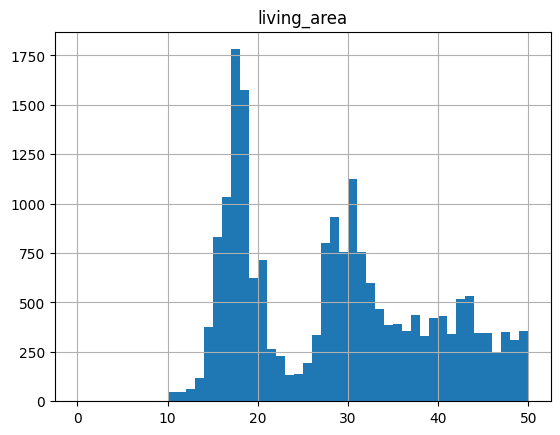

In [64]:
data.hist('living_area', bins=100, range=(0, 160))
data.hist('living_area', bins=50, range=(0, 50))
plt.show()

*Жилая площадь*: к сожалению, образовалось два пика данных, в значениях 18 и 30 кв м, что говорит о нарушении нормального распределения. Нам ещё предстоит выяснить, почему произошел просев в данных от 19 до 26 кв м. На данный момент можем предположить, что такой результат дала разница в количестве студий, однокомнатных и двухкомнатных квартир.

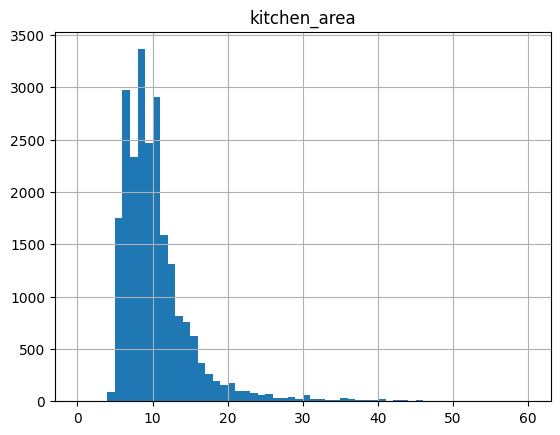

In [65]:
data.hist('kitchen_area', bins=60, range=(0, 60))
plt.show()

*Площадь кухни*: гистограмма говорит нам о нормальном распределении, пик значений приходится на 8 кв м. Данные выглядят реалистично.

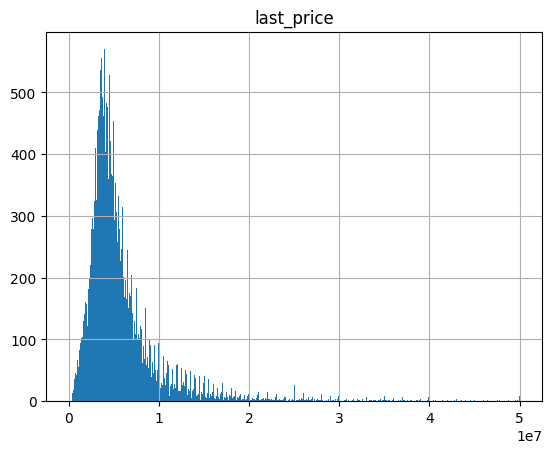

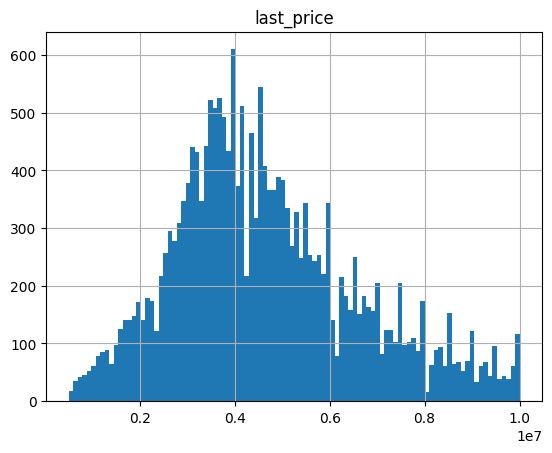

In [89]:
data.hist('last_price', bins=500, range=(0, 50000000))
data.hist('last_price', bins=100, range=(500000, 10000000))
plt.show()

*Цена объекта*: данные также имеют нормальное распределение. У общей гистограммы достаточно длинный хвост, что говорит о влиянии цен элитной недвижимости. Чуть ближе посмотрели пик значений, он приходится на примерное значение в 4 млн руб, что звучит более, чем реально.

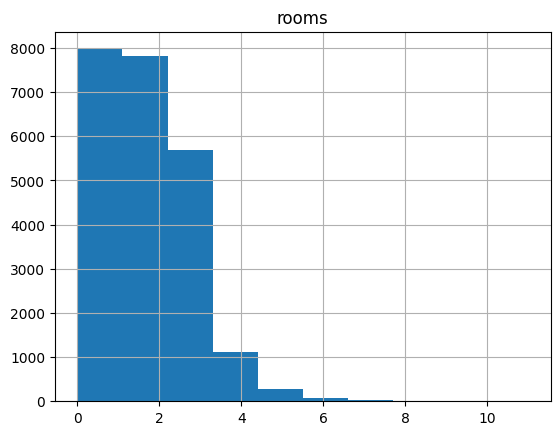

In [67]:
data.hist('rooms', bins=10, range=(0, 11))
plt.show()

*Количество комнат*: здесь видим по гистограмме распределение Пуассона, что также говорит о действительности данных. Большая часть объявлений приходится на студии, апартаменты и свободную планировку, а также однокомнатные квартиры.

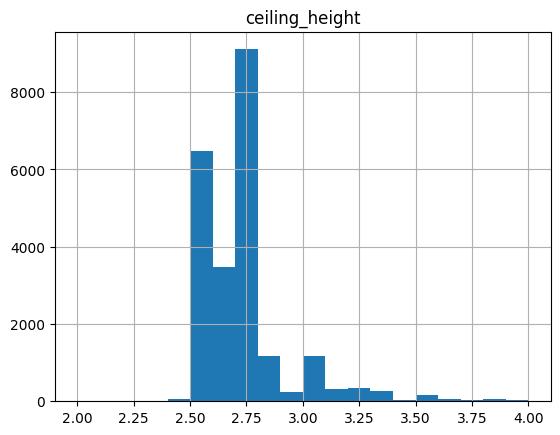

In [68]:
data.hist('ceiling_height', bins=20, range=(2, 4))
plt.show()

*Высота потолков*: гистограмма имеет вид нормального распределения данных, пик приходится на значения от 2,5 до 2,8 м.

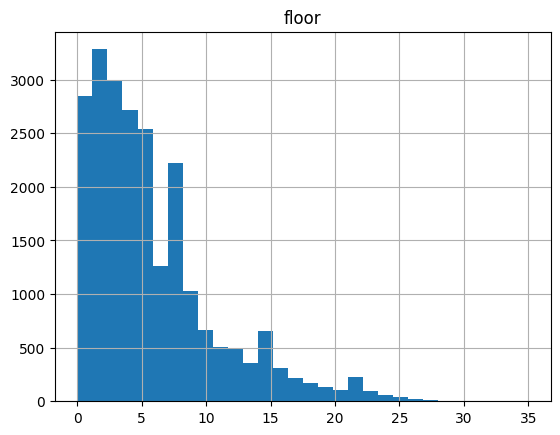

In [69]:
data.hist('floor', bins=30, range=(0, 35))
plt.show()

*Этаж квартиры*: данные выглядят реалистично, гистограмма в виде распределения Пуассона, пик находится от 1 до 5 этажа.

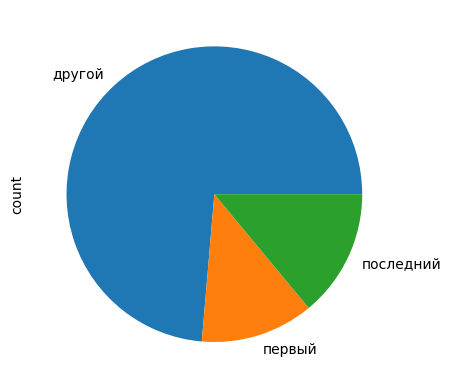

In [70]:
data.groupby(by='category_floor')['category_floor'].count().plot(kind='pie', ylabel = 'count')
plt.show()

*Тип этажа квартиры*: видим, что почти 75% процентов объявлений имеют тип этажа "другой", что похоже на действительность. Оставшиеся 30% делят между собой поровну категории "первый" и "последний".

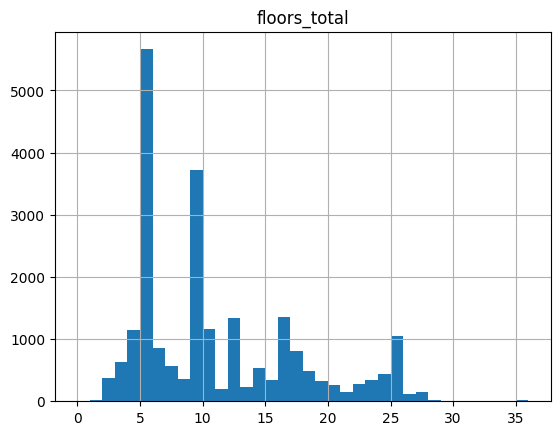

In [71]:
data.hist('floors_total', bins=36, range=(0, 36))
plt.show()

*Общее количество этажей в доме*: видим по графику несколько пиковых значений - 5, 9, 16 и 25 этажей, что достаточно типично для Санкт-Петербурга, поэтому принимаем, что данные распределены нормально.

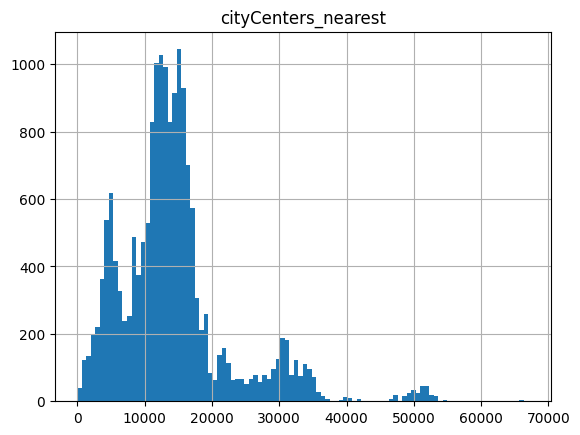

In [72]:
data.hist('cityCenters_nearest', bins=100, range=(0, 67000))
plt.show()

*Расстояние до центра города в метрах*: распределение похоже на нормальное, но заметим два явных пика - на 5 км и на 10-17 км.

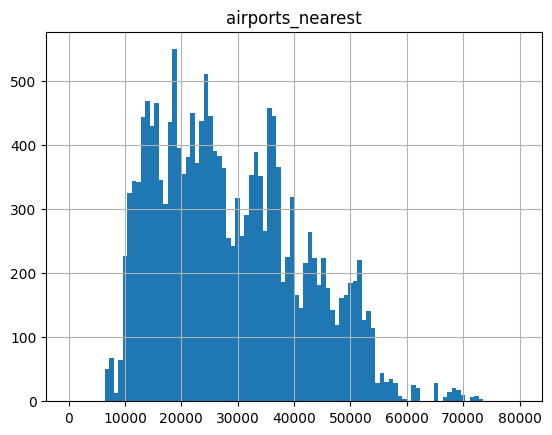

In [73]:
data.hist('airports_nearest', bins=100, range=(0, 80000))
plt.show()

*Расстояние до ближайшего аэропорт*: данные имеют распределение Пуассона, что не позволяет нам усомниться в их действительности.

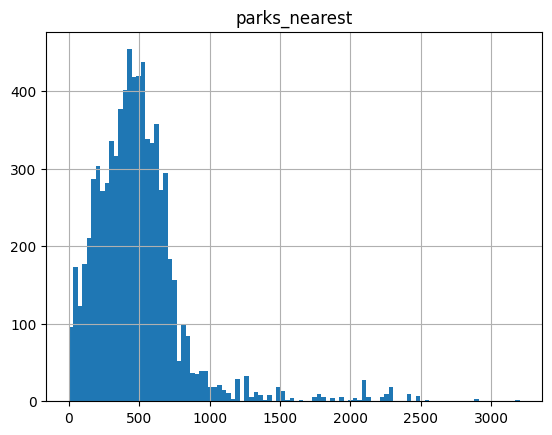

In [74]:
data.hist('parks_nearest', bins=100, range=(0, 3200))
plt.show()

*Расстояние до ближайшего парка*: данные предстают в нормальном распределении с длинным хвостиком.

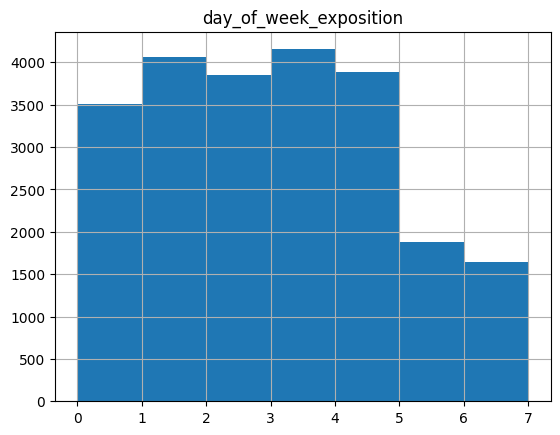

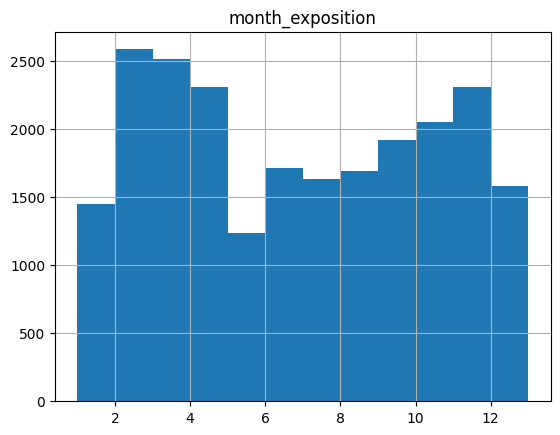

In [75]:
data.hist('day_of_week_exposition', bins=7, range=(0, 7))
data.hist('month_exposition', bins=12, range=(1, 13))
plt.show()

*День и месяц публикации объявления*: по дням видим распределение Пуассона, самое большое количество объявлений было размещено в будние дни, а в выходные данные немножко просели. По месяцам - среди самых пиковых и активных можно назвать периоды с февраля по апрель и с сентяюбря по ноябрь

### 2. Изучите, как быстро продавались квартиры

Построим гистограмму по столбцу **days_exposition**

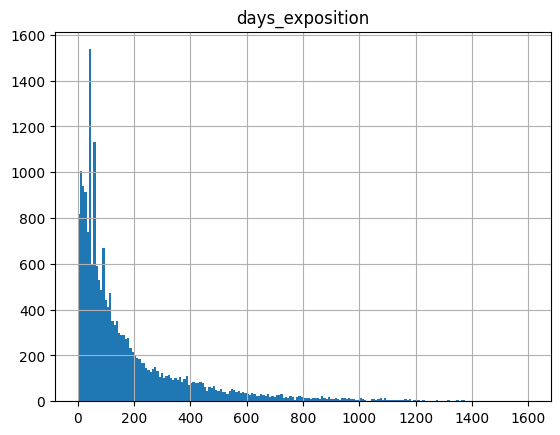

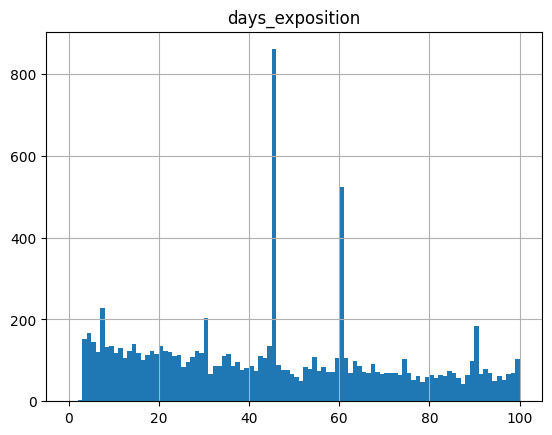

In [76]:
data.hist('days_exposition', bins=200, range=(0, 1600))
data.hist('days_exposition', bins=100, range=(0, 100))
plt.show()

На общей гистограмме можем заметить ярковыраженное рапсределние Пуасона, но с 3 конкретными точками выбросов. Посмотрим график поближе, чтобы выяснить, что это за точки. Видим пиковые значения - 45 и 60.

Далее расчитаем среднее и медианное значение для наших данных:

In [77]:
'Среднее количество дней, за которые продавалась квартира, составляет:', (data['days_exposition'].mean().astype('int'))

('Среднее количество дней, за которые продавалась квартира, составляет:', 155)

In [78]:
'Медианное количество дней, за которые продавалась квартира, составляет:', (data['days_exposition'].median().astype('int'))

('Медианное количество дней, за которые продавалась квартира, составляет:', 73)

Видим, что среднее значение больше чем в два раза превышает медианное. Посмотрим описательную статистику данных, чтобы составить окончательное мнение:

In [79]:
data['days_exposition'].describe()

,days_exposition
count,22974.000000
mean,155.896492
std,212.872435
min,-1.000000
25%,22.000000
50%,73.000000
75%,198.000000
max,1580.000000


Проведя расчеты, можем установить, что самым частым значением в продаже квартир является 45 дней. Это может быть обусловлено самой системой: например, автору объявления приходит уведомление по прошествию 1,5 месяцев с момента публикации объявления о несостоявшейся продаже и рекомендациями по улучшению объявления, автор решает объявить скидку или просто снизить цену и в ближайшие дни покупатель находится. Выбросы в значениии 60 тоже могут иметь подобную природу возникновения. Или возможно авторы самостоятельно не дожидаются покупки, снимают объявление и регистрируют его заново.

По квартилям можем сделать вывод, что нормальным временем продажи квартир является промежуток от 22 до 198 дней. Быстрыми продажами можем считать те, которые состоялись до 22 дней, а уже слишком долгими те объявления, которые находятся на ресурсе свыше 198 дней.

### 3. Какие факторы больше всего влияют на общую (полную) стоимость объекта?

Перед тем, как строить диаграммы для выборочных факторов, посмотрим на корреляцию каждого из них со стоимостью объекта. Для этого проведём неюольшие преобразования над столбцом **category_floor** и присвоим каждому показателю цифровое значение при помощи функции:

In [80]:
def category_floor_numeric(row):
    category_floor = row['category_floor']
    if category_floor == 'первый':
        return 1
    elif category_floor == 'другой':
        return 2
    else:
        return 3

data['category_floor_numeric'] = data.apply(category_floor_numeric, axis=1)

Далее создадим список с названиями столбцов тех факторов, которые необходимо проанализировать на взаимосвязь со стоимостью объекта, и вычислим корреляцию:

In [81]:
factors = ['total_area', 'living_area', 'kitchen_area', 'rooms', 'category_floor_numeric']

for factor in factors:
    print(f'Показатель корреляции между фактором {factor} и стоимостью квартиры состовляет:', data[factor].corr(data['last_price']).round(2))


Показатель корреляции между фактором total_area и стоимостью квартиры состовляет: 0.77
Показатель корреляции между фактором living_area и стоимостью квартиры состовляет: 0.67
Показатель корреляции между фактором kitchen_area и стоимостью квартиры состовляет: 0.6
Показатель корреляции между фактором rooms и стоимостью квартиры состовляет: 0.48
Показатель корреляции между фактором category_floor_numeric и стоимостью квартиры состовляет: 0.05


Уже можем сделать промежуточные выводы, что стоимость объекта положительно зависима от общей площади, жилищной площади, площади кухни и количества комнат. От остальных факторов зависимость практически отсутствует. Для визуализации расчётов и подкрепления выводов построим графики для каждого из факторов.

<Axes: xlabel='kitchen_area', ylabel='last_price'>

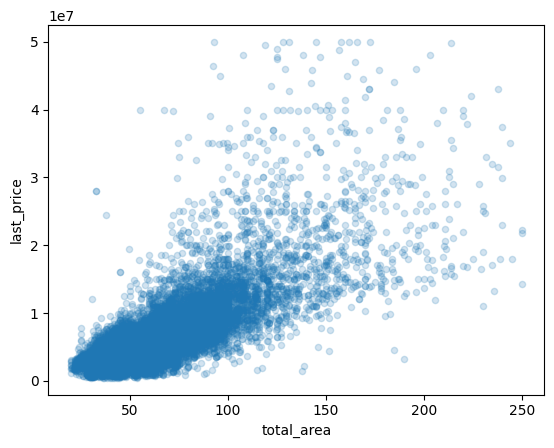

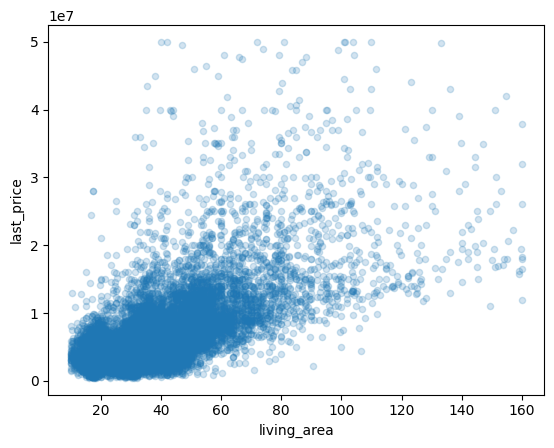

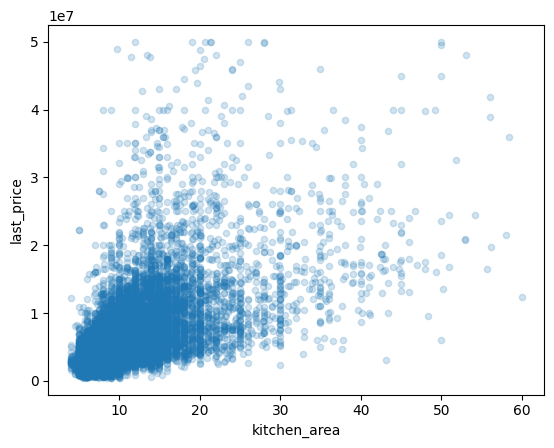

In [82]:
data.plot(x='total_area', y='last_price', kind='scatter', alpha=0.2)
data.plot(x='living_area', y='last_price', kind='scatter', alpha=0.2)
data.plot(x='kitchen_area', y='last_price', kind='scatter', alpha=0.2)

Для площадей построили три разных точечных диаграммы рассеяния. Видим, что они достаточно схожи между собой, а также можем наблюдать положительную корреляцию данных.

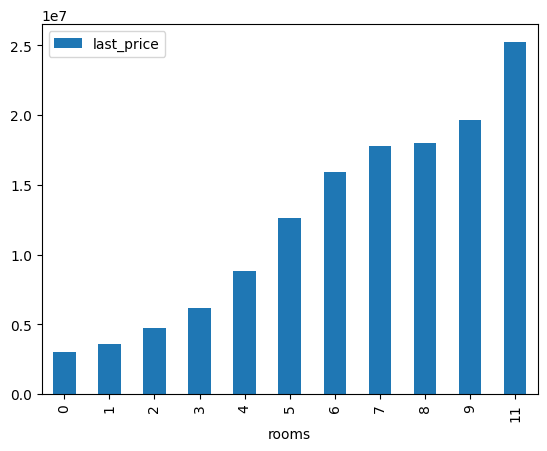

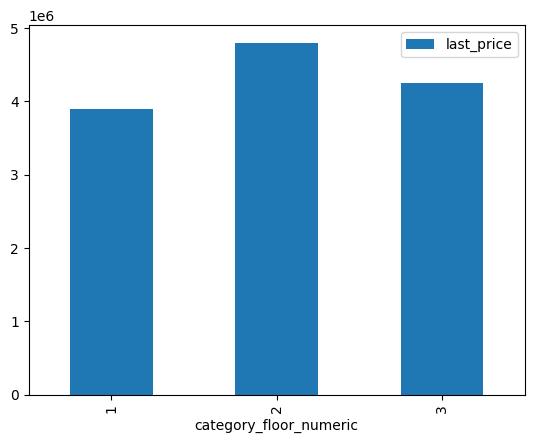

In [83]:
pd.pivot_table(data, index='rooms', values='last_price', aggfunc='median').plot(y='last_price', kind='bar')
pd.pivot_table(data, index='category_floor_numeric', values='last_price', aggfunc='median').plot(y='last_price', kind='bar')
plt.show()

По столбчатой диаграмме для количества комнат также наблюдаем положительную корреляцию от фактора, что логично - чем больше комнат, тем выше стоимость. По столбчатой диаграмме категории этажей (первый, последний, другой) видим отсутствие какой-либо зависимости, так как данные распределились практически равномерно.

<Axes: xlabel='year_exposition'>

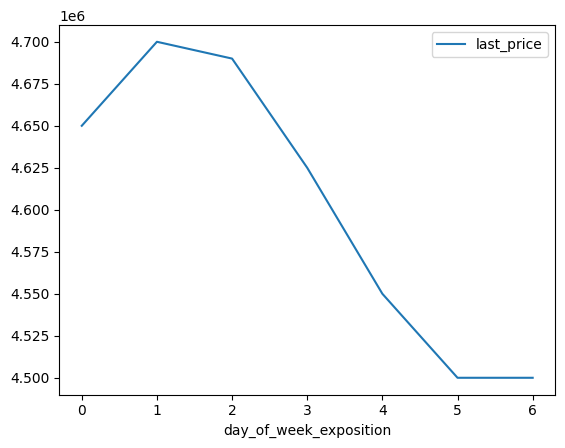

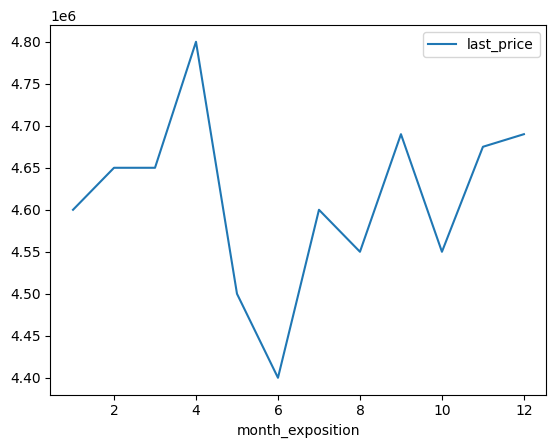

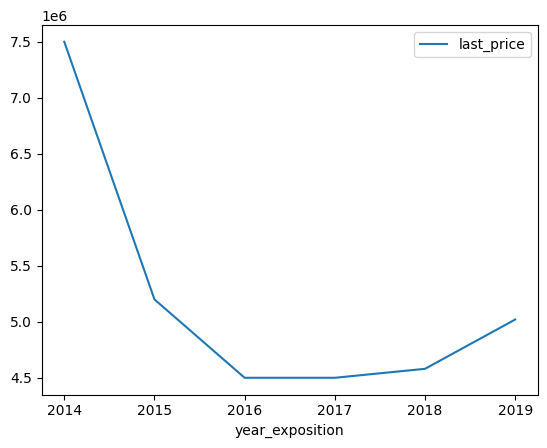

In [84]:
pd.pivot_table(data, index='day_of_week_exposition', values='last_price', aggfunc='median').plot(y='last_price', kind='line')
pd.pivot_table(data, index='month_exposition', values='last_price', aggfunc='median').plot(y='last_price', kind='line')
pd.pivot_table(data, index='year_exposition', values='last_price', aggfunc='median').plot(y='last_price', kind='line')

Для дат была выбрана линейная диаграмма, для каждого из трёх показателей (день, месяц и год) очевидно отсутствие какой-либо зависимости.

Следущие факторы больше всего влияют на общую стоимость объекта:
*   общая площадь
*   жилая площадь
*   площадь кухни
*   количество комнат





### 4. Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений

Чтобы решить данную задачу для начала необходимо отфильтровать данные о населённых пунктов по убыванию количества объявлений. Для этого создаём сводную таблицу с населёнными пунктами и медианными значениями цен за один квадратный метр и выберём первые 10 строчек.

In [85]:
pop_loc = pd.pivot_table(data, index='locality_name', values='price_for_one_meter_sqr', aggfunc=['count', 'median'])\
.sort_values(('count', 'price_for_one_meter_sqr'), ascending=False).head(10)
pop_loc.columns=['count', 'price_for_one_meter_sqr_median']
pop_loc

,count,price_for_one_meter_sqr_median
locality_name,,
санкт-петербург,15204,104358.025
поселок мурино,507,84876.540
поселок шушары,437,76829.270
всеволожск,394,65789.470
пушкин,359,99744.250
колпино,336,74689.875
поселок парголово,326,91780.225
гатчина,307,67796.610
поселок кудрово,286,91666.670


Большее количество объявлений размещенно в самом Санкт-Петербурге с количеством 15204, а за ним идёт с огромнейшим отрывом посёлок Мурино, в котором уже 507 объявлений. Теперь отсортируем получившийся список топ-10 населённых пунктов по убыванию цены за квадратный метро площади объекта.

In [86]:
pop_loc.sort_values('price_for_one_meter_sqr_median', ascending=False)

,count,price_for_one_meter_sqr_median
locality_name,,
санкт-петербург,15204,104358.025
пушкин,359,99744.250
поселок парголово,326,91780.225
поселок кудрово,286,91666.670
поселок мурино,507,84876.540
поселок шушары,437,76829.270
колпино,336,74689.875
гатчина,307,67796.610
всеволожск,394,65789.470


Выявили, что самый дорогой квадратный метр в Санкт-Петербурге (104 358 рублей), а самый дешёвый в Выборге (58 233 рублей).

<div class="alert alert-success">
<b>✔️ Комментарий ревьюера v1:</b>
<br>Всё верно! Как вариант, тут можно построить барплот для топ10 по средней цене, так будет более наглядно)
</div>

### 5. Выделите квартиры в Санкт-Петербурге с помощью столбца **locality_name** и вычислите среднюю цену каждого километра

Выделяем с помощью метода **query** срез объявлений по объектам из Санкт-Петербурга. Далее создаём сводную таблицу по удалённости объекта от центра и стоимости объектов и тут же строим столбчатых диаграмму.

<Axes: xlabel='cityCenters_nearest_km'>

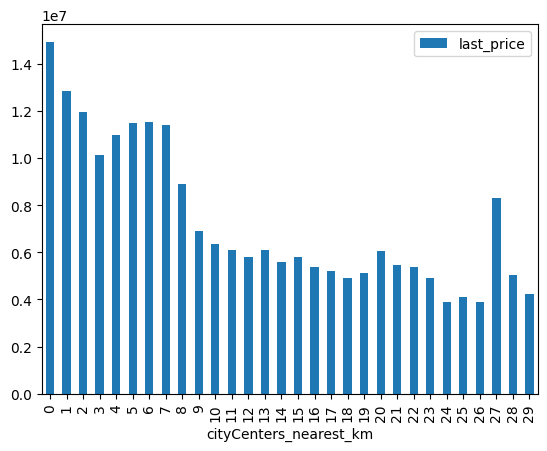

In [87]:
data.query('locality_name == "санкт-петербург"')\
.pivot_table(index='cityCenters_nearest_km', values='last_price')\
.plot(y='last_price', kind='bar')

По результатам видим, что чем дальше от центра квартира, тем дешевле. Дороже всего квартиры на расстоянии до 2 километров. Далее цена держится почти на ожном уровне от 4 до 7 километров и после идёт на спад. На 27 километре образуется пик в цене, который может быть обусловлен каким-то элитным районом на этом расстоянии.

Построим также сводную таблицу и диаграмму с ценой за один квадратный километр и рассмотрим результаты.

<Axes: xlabel='cityCenters_nearest_km'>

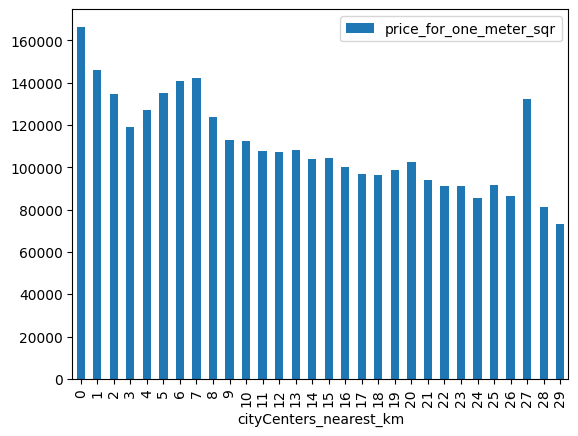

In [88]:
data.query('locality_name == "санкт-петербург"')\
.pivot_table(index='cityCenters_nearest_km', values='price_for_one_meter_sqr')\
.plot(y='price_for_one_meter_sqr', kind='bar')

Наблюдаем почти такую же картину, как и на предыдущем графике, что только укрепляет уверенность в построенных ранее выводах.

### Промежуточный вывод по четвёртому этапу:

Рассмотрели детально наши обработанные данные с помощью диаграмм и описательной характеристике по столбцам. Провели исследование по скорости продажи квартир и выявили быстрые (до 45 дней) и необычно медленные сроки продажи объектов (более 200 дней).

Далее рассмотрели более очевидные факторы, которые могли бы влиять на стоимость объектов недвижимости, и с помощью графиков и расчётов корреляции выяснили, какие именно (общая площадь, площадь жилой зоны, кухни и колчество комнат) напрямую могут влиять на стоимость квартиры.

Вычислили 10 самых популярных населённых пунктов по количеству размещённых объявлений и просортировали их по стоимость квартир за один квадратный метр, тем самым выяснив, какие районы являются самыми дорогостоящими (Санкт-Петербург).

Также просмотрели более детально данные по объявлениям, размещённым только в Санкт-Петербурге, и выявили зависимость стоимости квартир от близости к центру города с помощью сводных таблиц и столбчатых диаграмм (чем ближе квартира к центру, тем дороже её стоимость).

## Общий вывод

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет.

В ходе детальной предобработки данных (заполнение пропущенных значений, изменение типов данных под корректный, устранение дубликатов и удаление аномальных значений), добавления дополнительных столбцов для расчётов, а также в ходе исследований с использований графиков и описательной характеристики, мы пришли к некоторым важным выводам:

*   нормальным временем продажи квартир является промежуток от 22 до 198 дней. Быстрыми продажами можем считать те, которые состоялись до 22 дней, а уже слишком долгими те объявления, которые находятся на ресурсе свыше 198 дней.

*   следущие факторы больше всего влияют на общую стоимость объекта:
  * общая площадь
  * жилая площадь
  * площадь кухни
  * количество комнат

*   среди 10 самых популярных населённых пунктов по количеству размещённых объявлений самый дорогой квадратный метр в Санкт-Петербурге (104 358 рублей), а самый дешёвый в Выборге (58 233 рублей).

*   в Санкт-Петербурге чем дальше от центра квартира, тем дешевле. Дороже всего квартиры на расстоянии до 2 километров. Далее цена держится почти на ожном уровне от 4 до 7 километров и после идёт на спад. На 27 километре образуется пик в цене, который может быть обусловлен каким-то элитным районом на этом расстоянии.